## 21D008 Probabilistic Inference - Project: Elliptical Slice Sampling in Classification

In [1]:
import sys, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy
from scipy.stats import multivariate_normal
from numpy.random import multivariate_normal as mn
from gpc import *
from EllipticalSliceSampler import EllipticalSampler
from utils import (
    plot_sampler,
    plot_multiple,
    plot_contour,
    plot_ESS,
    plot_live,
    gaussian_kernel
)
np.random.seed(30)
cmap=colors.ListedColormap(["tab:cyan", "tab:green", "tab:gray"])

### Toy examples
This section presents mock examples to highlight some of the behavior our elliptical slice sampler exhibits, as well as to show the predictive performance of the sampler under baseline kernels and hyperparameters for both 1D and 2D Gaussian examples.  

#### Toy Example: Elliptical Slice Sampler

We define 

In [2]:
prior_µ = np.array([1,2])
prior_Σ = np.array(
    [[ 2.58319407, -0.67001488],
    [-0.67001488,  1.09846023]]
)

loglik = lambda f: np.log(multivariate_normal.pdf(f, mean=prior_µ, cov=prior_Σ))
f_incumbent = (mn(prior_µ - prior_µ, prior_Σ, size=1)).squeeze()

In [3]:
nu = mn(prior_µ - prior_µ, prior_Σ, size=1)
log_y = loglik(f_incumbent) + np.log(np.random.uniform(0,1))
Θ = np.random.uniform(0 + sys.float_info.min, 2*np.pi)
Θ_min, Θ_max = Θ - 2*np.pi, Θ

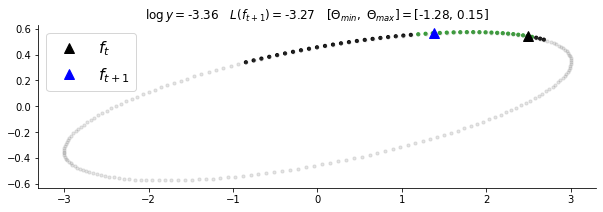

In [4]:
first, i = True, 0
while True:
    i+=1
    # try:
    f_candidate = (f_incumbent * np.cos(Θ) + nu * np.sin(Θ)).squeeze()
    plot_ESS(log_y, f_incumbent, f_candidate, Θ_min, Θ_max, nu, loglik, first=first, save=False, i=i, figsize=(10,3))
    time.sleep(1)
    if loglik(f_candidate) > log_y:
        f_incumbent = f_candidate
        break
    elif Θ < 0:
        Θ_min = Θ
    elif Θ > 0:
        Θ_max = Θ
    first=False
    Θ = np.random.uniform(Θ_min, Θ_max)

In [5]:
ess = EllipticalSampler(prior_μ=prior_μ, prior_Σ=prior_Σ, ll=loglik)
draws = ess.sample(num_samples=10000, num_burnin=1000, verbose=2)

100%|██████████| 10000/10000 [00:09<00:00, 1090.42it/s]


In [6]:
post_Σ = prior_Σ @ scipy.linalg.inv(2*prior_Σ) @ prior_Σ

# Posterior using analytical solution
print(post_Σ)

# Posterior Covariance from the Elliptical Slice Sampler 
np.cov(draws.T)

# Demean posterior observations
plot_draws = np.subtract(draws, np.mean(draws.T, axis=1))

# Draw topography for the analytical standard deviation
basespace = np.linspace(0,2*np.pi, 200)
points = np.array([np.cos(basespace),np.sin(basespace)])
sd_ellipse = np.linalg.cholesky(np.cov(draws.T)) @ points
sd2_ellipse = 2 * np.linalg.cholesky(np.cov(draws.T)) @ points

[[ 1.29159703 -0.33500744]
 [-0.33500744  0.54923011]]


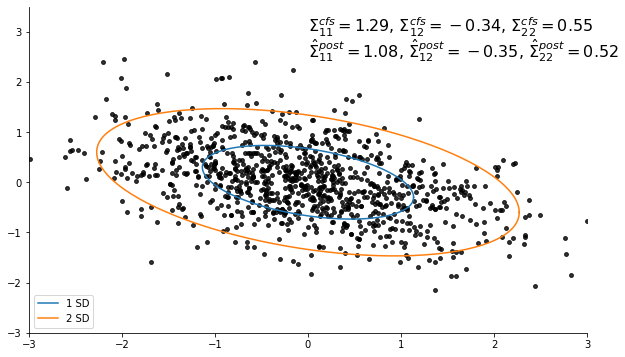

In [7]:
for i in range(20):
    data = plot_draws[:(i+1)*50]
    plot_live(data, prior_Σ, sd_ellipse, sd2_ellipse)
    time.sleep(1)

### Toy Example: GPC

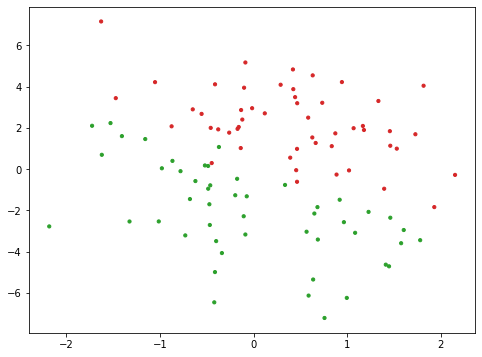

In [8]:
X1 = np.random.standard_normal(size=100)
X2 = np.random.normal(0,3,size=100)
X = np.dstack((X1,X2)).squeeze()
Y = np.where(0.5*X1 + 0.3*X2 + np.random.normal(0,0.2,100) > 0, 1, 0)

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.scatter(x=X[:,0], y=X[:,1], s=10, c=np.where(Y>0, "tab:red", "tab:green"))

In [6]:
train_X, train_Y = X[:80,:], Y[:80]
test_X, test_Y = X[80:,:], Y[80:]

In [7]:
gpc = GPC(kernel=gaussian_kernel, hyperparameters=[1,1])
gpc.X, gpc.Y = train_X, train_Y

In [8]:
y_pred, var_pred = gpc.predict(test_X)
prob_pred = GPC._sigmoid(y_pred)

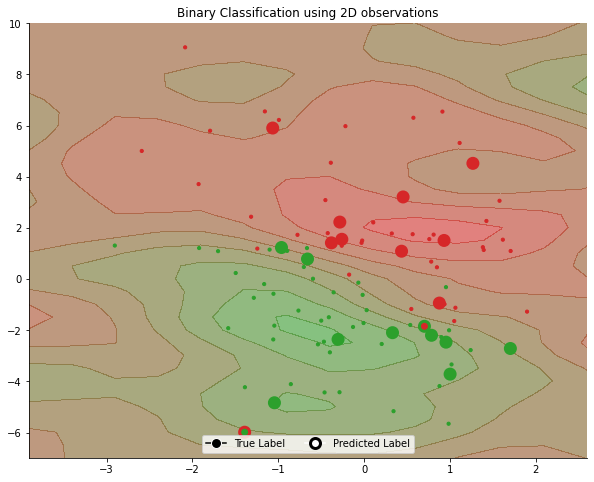

In [9]:
plot_contour(train_X, train_Y, test_X, test_Y, prob_pred, gpc, contour=True)